# Современные методы машинного обучения, ИАД

## Семинар 3

### О задании

Задание посвящено реализации различных слоёв нейронной сети.

In [7]:
import numpy as np

## Часть 1. Реализация слоёв графа вычислений

В этом задании мы реализуем граф вычислений для задачи распознавания изображений рукописных цифр на примере датасета [MNIST](http://yann.lecun.com/exdb/mnist/) — в частности, эта часть посвящена реализации всех требующихся для построения графа слоёв.

Указанная задача является задачей классификации на $K = 10$ классов, поэтому будем строить граф вычислений, выходной слой которого будет содержать 10 нейронов, $k$-ый из которых вычисляет оценку принадлежности объекта $k$-ому классу. В качестве функционала качества в данной задаче будем использовать **кросс-энтропию**:

$$Q(a, X) = -\frac{1}{l}\sum_{i=1}^l \sum_{k=1}^K [y_i = k] \log a_k(x_i),$$
где

$X = \{ (x_i, y_i)\}_{i=1}^l, \, y_i \in \{1, \dots, K\},$ — обучающая выборка,

$a(x) = (a_k(x))_{k=1}^K \in \mathbb{R}^K$ — прогноз графа вычислений для объекта $x$, состоящий из выходов $K$ нейронов выходного слоя (т.е. $a_k(x)$ — оценка принадлежности объекта $x$ классу $k$, построенная при помощи заданного графа вычислений).

Нейрнонные сети обучаются с использованием стохастических методов оптимизации, однако для ускорения обучения и большей стабильности за один проход параметры оптимизируются по батчу — набору из нескольких тренировочных примеров, так же batch_size является дополнительной размерностью для входящих в слой тензоров.

Для начала определим класс Layer, реализующий тождественный слой, который будет являться базовым классом для всех последующих.

In [1]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """

    def __init__(self):
        """
        Here you can initialize layer parameters (if any) and auxiliary stuff.
        """

        raise NotImplementedError("Not implemented in interface")

    def forward(self, input):
        """
        Takes input data of shape [batch, ...], returns output data [batch, ...]
        """

        raise NotImplementedError("Not implemented in interface")

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """

        raise NotImplementedError("Not implemented in interface")

**Задание 1**

Используя приведенные прототипы, реализуйте слой, применяющий функцию активации ReLU (Rectified Linear Unit) поэлементно к каждому из входов слоя:
$$\text{ReLU}(z) = \max (0, z)$$

In [2]:
class ReLU(Layer):

    def __init__(self):
        """
        ReLU layer simply applies elementwise rectified linear unit to all inputs
        This layer does not have any parameters.
        """
        pass

    def forward(self, input):
        """
        Perform ReLU transformation
        input shape: [batch, input_units]
        output shape: [batch, input_units]
        """
        output = np.maximum(0, input)
        return output

    def backward(self, input, grad_output):
        """
        Compute gradient of loss w.r.t. ReLU input
        """
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask

**Задание 2**

Используя указанные прототипы, реализуйте полносвязный слой, выход которого вычисляется следующим образом (подробнее в соответствующей [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/lecture-notes/lecture11-dl.pdf)):

$$f(v; W, b)= Wv + b, $$

где
* v — выход предыдущего слоя (вектор размера num_inputs);
* W — матрица весов [num_inputs, num_outputs];
* b — столбец свободных членов (вектор размера num_outputs).

При создании полносвязного слоя веса $W, \; b$ необходимо проинициализировать веса с помощью GLOROT (какой именно вариант неважно). Про GLOROT можно прочитать здесь:
1. Простой пост: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
2. Статья с математикой: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

При каждом вызове backward() необходимо расчитать градиенты по выходу, используя chain-rule, и сделать один шаг градиентного спуска.

In [3]:
class Dense(Layer):

    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = Wx + b

        W: matrix of shape [num_inputs, num_outputs]
        b: vector of shape [num_outputs]
        """

        self.learning_rate = learning_rate

        # initialize weights with small random numbers from normal distribution

        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)

    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        output_units = np.dot(input, self.weights) + self.biases
        return output_units

    def backward(self, input, grad_output):
        """
        Computes d f / d x = d f / d dense * d dense / d x,
        where d dense/ d x = weights transposed, and performs
        one step of gradient descent on W and b.

        input shape: [batch, input_units]
        grad_output: [batch, output units]

        Returns: grad_input, gradient of output w.r.t input
        """
        grad_input = grad_output.dot(self.weights.T)
        grad_weights = input.T.dot(grad_output)
        grad_biases = grad_output.sum(0)

        assert grad_weights.shape == self.weights.shape and \
            grad_biases.shape == self.biases.shape

        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

**Задание 3**

Как было сказано ранее, в качестве функционала качества в данной задаче мы будем использовать кросс-энтропию. Используя прототипы ниже, реализуйте вычисление данного функционала и его градиента по выходам графа вычислений.

Кросс-энтропия предполагает, что модель для каждого объекта выдает вероятности принадлежности к каждому из $K$ классов, т.е. что для одного объекта все $K$ вероятностей неотрицательны и суммируются в 1. В нашем же случае в построении графа участвуют только полносвязный и ReLU слои, а потому выходы графа не являются вероятностями — как правило, в этом случае прогноз $a(x)$ модели нормируется при помощи функции softmax следующим образом:

$$\text{softmax}(a_k(x)) = \frac{\exp(a_k(x))}{\sum_{k=1}^K \exp(a_k(x))}.$$

При реализации указанных функций предполагается, что переданные в качестве параметров оценки принадлежности объектов классам не являются нормированными (их еще называют логитами), но при вычислении указанных величин используйте указанное выше преобразование для приведения этих оценок к корректному виду.

In [4]:
def softmax_crossentropy_with_logits(logits, y_true):
    """
    Compute crossentropy from logits and ids of correct answers
    logits shape: [batch_size, num_classes]
    y_true: [batch_size]
    output is a number
    """
    logits_for_answers = logits[np.arange(len(logits)), y_true]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))
    return xentropy


def grad_softmax_crossentropy_with_logits(logits, y_true):
    """
    Compute crossentropy gradient from logits and ids of correct answers
    logits shape: [batch_size, num_classes]
    y_true: [batch_size]
    """
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), y_true] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

## Часть 2. Реализация и применение графа вычислений

В этой части мы научимся объединять слои в единый граф вычислений, а также использовать его для прямого прохода (вычисления прогнозов на объектах) и обратного прохода (обновление обучаемых параметров графа), после чего у нас появится возможность обучить граф. Для простоты реализации будем считать, что в нашем случае граф вычислений задается как список (python list) слоёв из числа реализованных ранее.

Ниже приведен код для скачивания датасета MNIST с официального сайта. Датасет делится на тренировочную и тестовую части. Тренировочная дополнительно разбивается на тренировочную и валидационную.

In [5]:
import sys
import os
import time
import gzip
from urllib.request import urlretrieve

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

Посмотрим на несколько объектов из этого датасета.

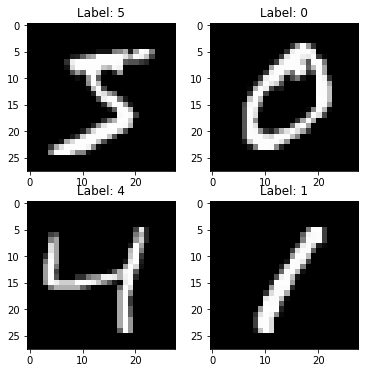

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]),cmap='gray');

**Задание 4 (2 балла).**

Используя прототип ниже, реализуйте прямой и обратный проход по графу вычислений и функцию для получения предсказаний метки класса.

In [9]:
class NeuralNetwork:
    def __init__(self, layers):
        """
        layers — list of Layer objects
        """
        
        self.layers = layers
        
    def forward(self, X):
        """
        Compute activations of all network layers by applying them sequentially.
        Return a list of activations for each layer. 
        Make sure last activation corresponds to network logits.
        """
        
        activations = []
        input = X

        for i in range(len(self.layers)):
            activations.append(self.layers[i].forward(input))
            input = activations[-1]

        assert len(activations) == len(self.layers)
        return activations

    def predict(self, X):
        """
        Use network to predict the most likely class for each sample.
        """
        return np.argmax(self.forward(X)[-1], axis=1)
        
    def backward(self, X, y):
        """
        Train your network on a given batch of X and y.
        You first need to run forward to get all layer activations.
        Then you can run layer.backward going from last to first layer.

        After you called backward for all layers, all Dense layers have already made one gradient step.
        """

        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
        logits = layer_activations[-1]

        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits, y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

        # propagate gradients through network layers using .backward
        # hint: start from last layer and move to earlier layers
        input_grad = loss_grad
        for i in range(len(layer_activations) - 1, -1, -1):
            input_grad = self.layers[i].backward(layer_inputs[i], input_grad)

        return np.mean(loss)

In [10]:
layers = []
hidden_layers_size = 40
layers.append(Dense(X_train.shape[1], hidden_layers_size))
layers.append(ReLU())
layers.append(Dense(hidden_layers_size, hidden_layers_size))
layers.append(ReLU())
layers.append(Dense(hidden_layers_size, 10))

model = NeuralNetwork(layers)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве должна превысить 97%. 

Ниже определена функции для итерации по батчам, принимающая на вход картинки, матки классов, а также размер батча и флаг отвечающий за перемешивание примеров.

In [11]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, seed=1234):
    assert len(inputs) == len(targets)
    
    indices = np.arange(len(inputs)).astype(np.int32)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        batch = indices[start_idx:start_idx + batchsize]
        
        yield inputs[batch], targets[batch]

Ниже приведены функции для обучения модели и отслеживания значения loss на тренироворочной части и на валидации.

In [12]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 4
Train accuracy: 0.97056
Val accuracy: 0.9642


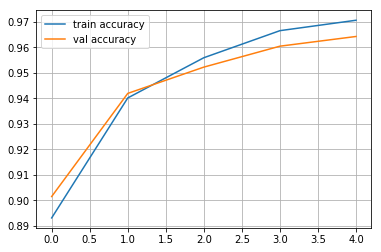

 82%|███████████████████████████████████████████████████████████████              | 1279/1562 [00:01<00:00, 858.95it/s]


KeyboardInterrupt: 

In [13]:
for epoch in range(15):
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        model.backward(x_batch, y_batch)
    
    train_log.append(np.mean(model.predict(X_train) == y_train))
    val_log.append(np.mean(model.predict(X_val) == y_val))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Часть 3. Tensorflow

В этой части мы увидим как с помощью фреймворков с автоматическим дифференцированием, создание нейронных сетей занимает намного меньше времени.

In [15]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

C:\Users\panov\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [17]:
model = Sequential()
model.add(Dense(hidden_layers_size, activation="relu"))
model.add(Dense(hidden_layers_size, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=32,
          epochs=15,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - ETA: 9:31 - loss: 2.3091 - acc: 0.031 - ETA: 24s - loss: 2.3240 - acc: 0.129 - ETA: 16s - loss: 2.2640 - acc: 0.17 - ETA: 11s - loss: 2.2030 - acc: 0.21 - ETA: 8s - loss: 2.1415 - acc: 0.2786 - ETA: 7s - loss: 2.0881 - acc: 0.323 - ETA: 6s - loss: 2.0259 - acc: 0.366 - ETA: 6s - loss: 1.9843 - acc: 0.392 - ETA: 5s - loss: 1.9441 - acc: 0.415 - ETA: 5s - loss: 1.9001 - acc: 0.438 - ETA: 5s - loss: 1.8673 - acc: 0.453 - ETA: 5s - loss: 1.8192 - acc: 0.475 - ETA: 5s - loss: 1.7879 - acc: 0.489 - ETA: 4s - loss: 1.7381 - acc: 0.508 - ETA: 4s - loss: 1.6936 - acc: 0.525 - ETA: 4s - loss: 1.6408 - acc: 0.542 - ETA: 4s - loss: 1.5949 - acc: 0.556 - ETA: 4s - loss: 1.5395 - acc: 0.574 - ETA: 3s - loss: 1.5020 - acc: 0.585 - ETA: 3s - loss: 1.4747 - acc: 0.594 - ETA: 3s - loss: 1.4319 - acc: 0.608 - ETA: 3s - loss: 1.3949 - acc: 0.618 - ETA: 3s - loss: 1.3647 - acc: 0.626 - ETA: 3s - loss

50000/50000 [==============================] - ETA: 10s - loss: 0.0714 - acc: 1.00 - ETA: 3s - loss: 0.1818 - acc: 0.9513 - ETA: 3s - loss: 0.2078 - acc: 0.938 - ETA: 3s - loss: 0.2028 - acc: 0.940 - ETA: 3s - loss: 0.2089 - acc: 0.939 - ETA: 3s - loss: 0.2064 - acc: 0.940 - ETA: 2s - loss: 0.2039 - acc: 0.941 - ETA: 2s - loss: 0.2131 - acc: 0.939 - ETA: 2s - loss: 0.2112 - acc: 0.938 - ETA: 2s - loss: 0.2103 - acc: 0.939 - ETA: 2s - loss: 0.2099 - acc: 0.940 - ETA: 2s - loss: 0.2104 - acc: 0.939 - ETA: 2s - loss: 0.2129 - acc: 0.938 - ETA: 2s - loss: 0.2114 - acc: 0.939 - ETA: 2s - loss: 0.2137 - acc: 0.938 - ETA: 2s - loss: 0.2107 - acc: 0.939 - ETA: 2s - loss: 0.2098 - acc: 0.940 - ETA: 2s - loss: 0.2093 - acc: 0.940 - ETA: 2s - loss: 0.2086 - acc: 0.941 - ETA: 2s - loss: 0.2080 - acc: 0.941 - ETA: 2s - loss: 0.2102 - acc: 0.939 - ETA: 2s - loss: 0.2109 - acc: 0.939 - ETA: 2s - loss: 0.2100 - acc: 0.939 - ETA: 2s - loss: 0.2099 - acc: 0.939 - ETA: 2s - loss: 0.2107 - acc: 0.939 - ET

50000/50000 [==============================] - ETA: 10s - loss: 0.1008 - acc: 0.96 - ETA: 3s - loss: 0.1389 - acc: 0.9505 - ETA: 3s - loss: 0.1276 - acc: 0.957 - ETA: 3s - loss: 0.1370 - acc: 0.956 - ETA: 4s - loss: 0.1427 - acc: 0.956 - ETA: 3s - loss: 0.1376 - acc: 0.958 - ETA: 3s - loss: 0.1404 - acc: 0.957 - ETA: 3s - loss: 0.1455 - acc: 0.956 - ETA: 3s - loss: 0.1501 - acc: 0.954 - ETA: 3s - loss: 0.1506 - acc: 0.954 - ETA: 3s - loss: 0.1518 - acc: 0.954 - ETA: 3s - loss: 0.1502 - acc: 0.954 - ETA: 3s - loss: 0.1503 - acc: 0.954 - ETA: 3s - loss: 0.1514 - acc: 0.954 - ETA: 3s - loss: 0.1496 - acc: 0.955 - ETA: 3s - loss: 0.1506 - acc: 0.955 - ETA: 2s - loss: 0.1523 - acc: 0.955 - ETA: 2s - loss: 0.1554 - acc: 0.954 - ETA: 2s - loss: 0.1568 - acc: 0.954 - ETA: 2s - loss: 0.1566 - acc: 0.954 - ETA: 2s - loss: 0.1565 - acc: 0.954 - ETA: 2s - loss: 0.1562 - acc: 0.954 - ETA: 2s - loss: 0.1556 - acc: 0.954 - ETA: 2s - loss: 0.1558 - acc: 0.954 - ETA: 2s - loss: 0.1577 - acc: 0.953 - ET

50000/50000 [==============================] - ETA: 10s - loss: 0.1053 - acc: 0.96 - ETA: 3s - loss: 0.1196 - acc: 0.9625 - ETA: 3s - loss: 0.1245 - acc: 0.959 - ETA: 3s - loss: 0.1195 - acc: 0.960 - ETA: 3s - loss: 0.1234 - acc: 0.961 - ETA: 3s - loss: 0.1316 - acc: 0.958 - ETA: 4s - loss: 0.1263 - acc: 0.961 - ETA: 4s - loss: 0.1254 - acc: 0.961 - ETA: 4s - loss: 0.1276 - acc: 0.960 - ETA: 4s - loss: 0.1245 - acc: 0.962 - ETA: 4s - loss: 0.1288 - acc: 0.962 - ETA: 4s - loss: 0.1257 - acc: 0.962 - ETA: 4s - loss: 0.1271 - acc: 0.962 - ETA: 4s - loss: 0.1277 - acc: 0.961 - ETA: 4s - loss: 0.1272 - acc: 0.962 - ETA: 4s - loss: 0.1264 - acc: 0.962 - ETA: 3s - loss: 0.1275 - acc: 0.962 - ETA: 3s - loss: 0.1255 - acc: 0.962 - ETA: 3s - loss: 0.1284 - acc: 0.961 - ETA: 3s - loss: 0.1290 - acc: 0.961 - ETA: 3s - loss: 0.1312 - acc: 0.960 - ETA: 3s - loss: 0.1316 - acc: 0.960 - ETA: 3s - loss: 0.1327 - acc: 0.960 - ETA: 3s - loss: 0.1318 - acc: 0.960 - ETA: 3s - loss: 0.1321 - acc: 0.960 - ET